In [1]:
import sys
sys.path.append('../../../GraphGallery/')
sys.path.append('../../../GraphAdv/')

import numpy as np

from graphgallery.nn.models import GCN
from graphadv.attack.untargeted import Metattack
from graphadv.defense import JaccardDetection, CosinDetection

import matplotlib.pyplot as plt

In [2]:
from graphgallery.data import NPZDataset
data = NPZDataset('citeseer', root="~/GraphData/datasets/", verbose=False, standardize=True)
adj, x, labels = data.graph.unpack()
idx_train, idx_val, idx_test = data.split(random_state=15)


Downloaded dataset files have existed.
Processing...
Processing completed.


In [3]:
idx_unlabeled = idx_test
# idx_unlabeled = np.hstack([idx_val, idx_test])

In [4]:
attacker = Metattack(adj, x, labels, 
                     idx_train, idx_unlabeled=idx_unlabeled, 
                     lr=0.01, # cora and cora_ml lr=0.1 citeseer lr=0.01
                     lambda_=1.0,
                     device="GPU", seed=None)
attacker.reset()
attacker.attack(0.05, structure_attack=True, feature_attack=False)
# show logs
attacker.show_edge_flips(detail=False)

Peturbing Graph: 100%|██████████| 183/183 [01:35<00:00,  2.20it/s]

Flip 183 edges, 183 added, 0 removed. Added edges with different classes: 100.00%, removed edges with the same classes: 0.00%


# Before Attack

In [5]:
model_before = GCN(adj, x, labels, device='GPU', norm_x=None, seed=42)
model_before.build()
his_before = model_before.train(idx_train, verbose=1, epochs=100)
loss, accuracy = model_before.test(idx_test)
print(f'Test loss {loss:.5}, Test accuracy {accuracy:.2%}')

<Loss = 0.1372 Acc = 0.9953 >: 100%|██████████| 100/100 [00:01<00:00, 86.09it/s]


Test loss 1.321, Test accuracy 71.09%


# After Attack

In [6]:
model_after = GCN(attacker.A, x, labels, device='GPU', norm_x=None, seed=42)
model_after.build()
his_after = model_after.train(idx_train, verbose=1, epochs=100)
loss, accuracy = model_after.test(idx_test)
print(f'Test loss {loss:.5}, Test accuracy {accuracy:.2%}')

<Loss = 0.1492 Acc = 0.9953 >: 100%|██████████| 100/100 [00:00<00:00, 120.75it/s]


Test loss 1.3901, Test accuracy 64.69%


# After Defense

+ `JaccardDetection` for binary node attributes
+ `CosinDetection` for continuous node attributes

In [11]:
defender = JaccardDetection(adj, x)
defender.reset()
defender.fit()

In [12]:
model_defense = GCN(defender.A, x, labels, device='GPU', norm_x=None, seed=42)
model_defense.build()
his_defense = model_defense.train(idx_train, verbose=1, epochs=100)
loss, accuracy = model_defense.test(idx_test)
print(f'Test loss {loss:.5}, Test accuracy {accuracy:.2%}')

<Loss = 0.1339 Acc = 0.9953 >: 100%|██████████| 100/100 [00:01<00:00, 30.52it/s]


Test loss 1.2497, Test accuracy 71.45%


#  Visulation

In [13]:
def plot(his_before, his_after, his_defense, metric="loss"):
    with plt.style.context(['science', 'no-latex']):
        plt.plot(his_before.history[metric])
        plt.plot(his_after.history[metric])
        plt.plot(his_defense.history[metric])        
        plt.legend([f'{metric.title()} Before Attack', f'{metric.title()} After Attack', f'{metric.title()} After defense'])
        plt.ylabel(f'{metric.title()}')
        plt.xlabel('Epochs')
        plt.show()    

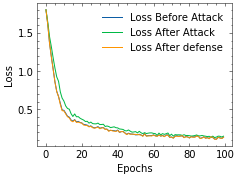

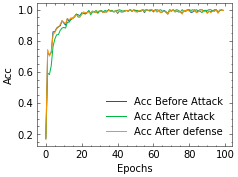

In [14]:
plot(his_before, his_after, his_defense, metric="loss")
plot(his_before, his_after, his_defense, metric="acc")